<a href="https://colab.research.google.com/github/prakritipaul/mhcglobe/blob/main/v2_BERT_MHCGlobe_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Features Prediction Pipeline with Neptune Integration

1. Got BERT embeddings for 1000 training/es_allele/peptide_pseudosxns.
2. Has new model that integrates new "preprocessing" dense layer.

- Have an end-to-end pipeline (to be cleaned up for future)
- Has predictions based on training + early stopping of 1000/5000 samples.
- Includes neptune integration of runs + model!



In [1]:
!git clone https://github.com/prakritipaul/mhcglobe.git

Cloning into 'mhcglobe'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 762 (delta 124), reused 204 (delta 120), pack-reused 549
Receiving objects: 100% (762/762), 113.07 MiB | 25.29 MiB/s, done.
Resolving deltas: 100% (422/422), done.
Updating files: 100% (200/200), done.
Error downloading object: data/distB62_unique_pseudpsequences.pkl (d151a08): Smudge error: Error downloading data/distB62_unique_pseudpsequences.pkl (d151a0800777499690d258210735bbe1bf8f627fedc59b579281582b6a03b3da): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/mhcglobe/.git/lfs/logs/20240405T161631.794923279.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: data/distB62_unique_pseudpsequences.pkl: smudge filter lfs failed
You can i

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import joblib as jb

import sys
sys.path.append("/content/mhcglobe/src")
import mhcglobe
import mhc_data
import inequality_loss
import train_functions as trainf
import binding_affinity as ba
import sequence_functions as seqf
import prakriti_helper_functions as phf

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install neptune
import neptune

from google.colab import userdata
NEPTUNE_API_TOKEN = userdata.get('NEPTUNE_API_TOKEN')

In [182]:
# Neptune
run = neptune.init_run(project="ppaul/MHC-BERT",
    api_token=NEPTUNE_API_TOKEN,
    tags = ["BERT", "eric model_1+Dense Layer Dim Reduction", "MM_4/12/24", "es 5000 -> 1000; train = 5000"],
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ppaul/MHC-BERT/e/MHCBER-10


In [17]:
# In case you have to access a previous run.

run = neptune.init_run(project="ppaul/MHC-BERT",
    api_token=NEPTUNE_API_TOKEN,
    with_id="MHCBER-6",
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ppaul/MHC-BERT/e/MHCBER-6


### Get data
Contains both BA+EL, human and non-human

In [163]:
# 729,538/1,229,838
pMHC = mhc_data.pMHC_Data(only_EL=False, drop_duplicate_records=True)
pMHC_data = pMHC.data

#### Randomly pick 100 HLA-peptide peptide + Remove them from training data
These will be the test set, and is the same number of examples as in Eric's example df.   

In [164]:
# 678024
# Note: ba = 89529 (13%), sa/ma = 588495 (87%)
human_pMHC_data = pMHC_data[pMHC_data["allele"].str.contains("HLA")]
# 12% ba's
human_pMHC_data_test = human_pMHC_data.sample(n=100, random_state=428364)

# Seeing what happens if I only have ='s
# human_pMHC_data_test = human_pMHC_data.iloc[:100]

In [165]:
# 729438
pMHC_data_train = pMHC_data[~pMHC_data.index.isin(human_pMHC_data_test.index)]

#### Reset Indices to prevent any issues downstream

In [166]:
pMHC_data_train = pMHC_data_train.reset_index(drop=True)
human_pMHC_data_test = human_pMHC_data_test.reset_index(drop=True)

In [167]:
pMHC_data_train.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*03:01,IEDB,=,BA,340.633333,EVMPVSMAK,HLA-A,True,True
1,HLA-A*11:01,IEDB,=,BA,17.140000,EVMPVSMAK,HLA-A,True,True
2,HLA-A*03:01,IEDB,=,BA,219.816667,KTFPPTEPK,HLA-A,True,True
3,HLA-A*11:01,IEDB,=,BA,222.213333,KTFPPTEPK,HLA-A,True,True
4,HLA-A*03:01,IEDB,=,BA,57.250000,RLYYDSMSY,HLA-A,True,True
5,HLA-A*11:01,IEDB,=,BA,237.025000,RLYYDSMSY,HLA-A,True,True
6,HLA-A*11:01,IEDB,=,BA,56.833333,AVLQSGFRK,HLA-A,True,True
7,HLA-A*03:01,IEDB,=,BA,2069.000000,KCYGVSATK,HLA-A,True,True
8,HLA-A*11:01,IEDB,=,BA,8375.750000,KCYGVSATK,HLA-A,True,True
9,HLA-A*03:01,IEDB,=,BA,188.033333,QLFKPLTKK,HLA-A,True,True


In [168]:
human_pMHC_data_test.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*02:06,IEDB,<,SA,100.0,RVVDYLTKL,HLA-A,True,True
1,HLA-B*27:05,IEDB,<,SA,100.0,TRYQTFVNF,HLA-B,True,True
2,HLA-A*02:12,S3_Only,>,BA,20000.0,AARHKHQVM,HLA-A,True,True
3,HLA-B*07:02,IEDB,<,SA,100.0,IPRSILMTTF,HLA-B,True,True
4,HLA-B*27:05,S3_Only,<,SA,100.0,SRVMDFFRR,HLA-B,True,True
5,HLA-C*12:02,IEDB,<,SA,100.0,STDPRPASY,HLA-C,True,True
6,HLA-B*35:03,MHCFlury2_S1,<,MA,100.0,SPHGIASVL,HLA-B,True,True
7,HLA-B*49:01,IEDB,<,SA,100.0,IEESGEHII,HLA-B,True,True
8,HLA-A*36:01,IEDB,<,SA,100.0,SLAMEMVLTGDR,HLA-A,True,True
9,HLA-B*35:07,IEDB,<,SA,100.0,MPFDFRRFDIY,HLA-B,True,True


#### Make csv's that have all columns + save in Neptune

In [169]:
# Make a csv file that can be stored in neptune
pMHC_data_train.to_csv("/content/mhcglobe/example/all_columns_pMHC_data_train_428364.csv", index=False)
human_pMHC_data_test.to_csv("/content/mhcglobe/example/all_columns_human_pMHC_data_test_428364.csv", index=False)

In [183]:
# Neptune
run["data/all_columns_training"].upload("/content/mhcglobe/example/all_columns_pMHC_data_train_428364.csv")
run["data/all_columns_testing"].upload("/content/mhcglobe/example/all_columns_human_pMHC_data_test_428364.csv")

#### Get 4 relevant columns

In [171]:
pMHC_data_train = pMHC_data_train[["allele", "peptide", "measurement_inequality", "measurement_value"]]
human_pMHC_data_test = human_pMHC_data_test[["allele", "peptide", "measurement_inequality", "measurement_value"]]

In [172]:
pMHC_data_train.head(10)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*03:01,EVMPVSMAK,=,340.633333
1,HLA-A*11:01,EVMPVSMAK,=,17.140000
2,HLA-A*03:01,KTFPPTEPK,=,219.816667
3,HLA-A*11:01,KTFPPTEPK,=,222.213333
4,HLA-A*03:01,RLYYDSMSY,=,57.250000
5,HLA-A*11:01,RLYYDSMSY,=,237.025000
6,HLA-A*11:01,AVLQSGFRK,=,56.833333
7,HLA-A*03:01,KCYGVSATK,=,2069.000000
8,HLA-A*11:01,KCYGVSATK,=,8375.750000
9,HLA-A*03:01,QLFKPLTKK,=,188.033333


In [173]:
human_pMHC_data_test.head(10)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*02:06,RVVDYLTKL,<,100.0
1,HLA-B*27:05,TRYQTFVNF,<,100.0
2,HLA-A*02:12,AARHKHQVM,>,20000.0
3,HLA-B*07:02,IPRSILMTTF,<,100.0
4,HLA-B*27:05,SRVMDFFRR,<,100.0
5,HLA-C*12:02,STDPRPASY,<,100.0
6,HLA-B*35:03,SPHGIASVL,<,100.0
7,HLA-B*49:01,IEESGEHII,<,100.0
8,HLA-A*36:01,SLAMEMVLTGDR,<,100.0
9,HLA-B*35:07,MPFDFRRFDIY,<,100.0


### Balance the dataset to get X_tr, Y_tr, X_es, Y_es!


In [11]:
# Returns a data frame with cols
# test (is it es or not), allele, peptide, measurement_inequality, measurement_value
train, es = trainf.BalanceSplitData().get_train_val(pMHC_data_train)

# reset indices to prevent downstream issues
# 583650
train = train.reset_index(drop=True)
# 145788
es = es.reset_index(drop=True)

#### Save these!

In [188]:
train_csv_name = "/content/mhcglobe/example/train_428364_24_04_05.csv"
es_csv_name = "/content/mhcglobe/example/es_428364_24_04_05_es.csv"
# es_csv_name = "/content/mhcglobe/example/es_428364_24_04_05_es_1000.csv"

In [189]:
train.to_csv(train_csv_name, index=False)
es.to_csv(es_csv_name, index=False)

In [190]:
# Neptune
run["data/train_428364_24_04_05"].upload(train_csv_name)
run["data/es_428364_24_04_05_es"].upload(es_csv_name)
# run["data/es_428364_24_04_05_es_1000"].upload(es_csv_name)

### REMOVE THIS LATER: just a test!

In [191]:
train, es = train.iloc[:5000], es.iloc[:1000]

In [192]:
train

,test,allele,peptide,measurement_inequality,measurement_value
0,False,HLA-B*18:03,DDFESKYSF,<,100.0
1,False,HLA-B*18:03,DDFLNRIAL,<,100.0
2,False,HLA-B*18:03,DEAFVREV,<,100.0
3,False,HLA-B*18:03,DEAKFPTM,<,100.0
4,False,HLA-B*18:03,DEAKLIAV,<,100.0
...,...,...,...,...,...
4995,False,HLA-B*42:01,RPINALDEL,<,100.0
4996,False,HLA-B*42:01,RPIQPIAGL,<,100.0
4997,False,HLA-B*42:01,RPKAISPYHL,<,100.0
4998,False,HLA-B*42:01,RPKALTQVL,<,100.0


In [193]:
es

,test,allele,peptide,measurement_inequality,measurement_value
0,True,HLA-B*18:03,DEAYKILAH,<,100.0
1,True,HLA-B*18:03,DEFAKLQDY,<,100.0
2,True,HLA-B*18:03,DEFANLIQH,<,100.0
3,True,HLA-B*18:03,DEFGHTSQL,<,100.0
4,True,HLA-B*18:03,DEFPLLTTK,<,100.0
...,...,...,...,...,...
995,True,HLA-B*44:09,AESIVVHTY,<,100.0
996,True,HLA-B*44:09,AEVGVLVGKDRSSF,<,100.0
997,True,HLA-B*44:09,DPQSPMAGL,<,100.0
998,True,HLA-B*44:09,EEMDLKVLQF,<,100.0


### Get MHC pseudosxns (X1_train, X1_es)- should be a function
Returns a list.

In [194]:
def get_allele_pseudoseqs(train_or_es, mhc_data):
  """
    Gets pseudosquences for MHC alleles present in a train or es dataframe.

    Args:
      train_or_es: Data frame with cols
        test (is it es or not), allele, peptide, measurement_inequality, measurement_value

      mhc data object: used to make allele2seq dict.
        e.g. pMHC = mhc_data.pMHC_Data
        {'HLA-A*02:560': 'YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYEWY'...}

    Returns:
      allele_pseudoseqs: list of shape (n_alleles, 34)
"
    Example:
      'DLA-88*508:01', 'Mamu-B*08:01' -> 'YYATYGEKVETVYVDTLYITYRDYTWAVWNYTWY',
                                         'YSSEYEERAGHTDADTLYLTYHYYTWAEVAYTWY'
  """
  mhc_alleles = train_or_es["allele"]
  allele2seq_dict = mhc_data.allele2seq

  allele_pseudoseqs = [str(allele2seq_dict[a]) for a in mhc_alleles]
  return allele_pseudoseqs

In [195]:
# X1_train, X1_es
training_allele_pseudoseqs = get_allele_pseudoseqs(train, pMHC)
es_allele_pseudoseqs = get_allele_pseudoseqs(es, pMHC)

### Get MHCFlurry representations of peptides (X2_train, X2_es)
Returns a list.

Basically change "seq_to_15mer" function to just get the amino acids of the representation.

In [196]:
def get_mhcflurry_representation(peptide):
  """
    Given a peptide sequence, return the mhcflurry representation.

    Examples:
      Example 1: ARDV (4) -> ARDV-X7-ARDV
	    Example 2: ARDVA (5) -> ARDV-X7-RDVA
      Example 3: ARDVAA (6) -> ARDV-X7-DVAA
        (X7 padding is true until len(peptide) = 8)
      Example 4: ARDVAAAAA (9) -> ARDV-XXX-A-XXX-AAAA
      Example 5: ARDVAAAAAA (10) -> ARDV-XXX-AA-XX-AAAA
  """
  middle_AAs = peptide[4:-4]
  num_X = 15-(len(middle_AAs)+8)

  if num_X%2 == 0:
    pad_len = num_X//2
    middle_AAs_with_pad = "X"*pad_len + middle_AAs + "X"*pad_len

  else:
    pad_len_left = num_X//2 + 1
    pad_len_right = pad_len_left - 1
    middle_AAs_with_pad = "X"*pad_len_left + middle_AAs + "X"*pad_len_right

  mhcflurry_representation = peptide[:4] + middle_AAs_with_pad + peptide[-4:]
  return mhcflurry_representation

In [197]:
def get_peptide_pseudoseqs(train_or_es):
  """
    Same function as "get_allele_pseudoseqs", but for peptides.

    Returns:
      peptide_pseudoseqs:
        list of shape (n_peptides, 15)
  """
  peptides = train_or_es["peptide"]
  peptide_pseudoseqs = [get_mhcflurry_representation(p) for p in peptides]
  return peptide_pseudoseqs

In [198]:
# X2_train, X2_es
training_peptide_pseudoseqs = get_peptide_pseudoseqs(train)
es_peptide_pseudoseqs = get_peptide_pseudoseqs(es)

### Get BERT representation of both MHC and peptides (X1_train', X1_es', X2_train', X2_es')
https://github.com/facebookresearch/esm/issues/348

FUTURE IMPROVEMENT:
Add a functionality where the attention mask is 0 wherever there's an X in the AA sxn (peptide).

In [199]:
def get_BERT_embeddings(aa_sxns, tokenizer, model, return_tensors):
  """
    Gets features of alleles or peptides from a BERT-like model, like ESM2.

    Args:
      aa_sxns: list of amino acid sequences.
        e.g. training/es_allele_pseudoseqs, training_peptide/es_pseudoseqs

      tokenizer: tokenizer for the model from huggingface.
      model: model for the model from huggingface.
      return_tensors: "tf" or "pt"

    Returns:
      PyTorch/Tensorflow tensors of shape n_alleles/peptides x 34/15 x n_embedding_dims
        e.g. n_embedding_dims = 320 for ESM2_t6_8M_UR50D.
        Note: embeddings are from the last hidden state of the model.

    Example:
      tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
      model = TFEsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
      get_BERT_embeddings(training_allele_pseudoseqs, tokenizer, model, "tf")
  """
  inputs = tokenizer(aa_sxns, return_tensors=return_tensors, padding=False, truncation=False)
  input_ids = inputs["input_ids"]
  attention_mask = inputs["attention_mask"]
  # Update them to not have <cls> and <eos> tokens.
  updated_input_ids = input_ids[:, 1:-1]
  updated_attention_mask = attention_mask[:, 1:-1]
  updated_inputs = {"input_ids": updated_input_ids, "attention_mask": updated_attention_mask}
  # Get outputs
  outputs = model(**updated_inputs)
  # Get last_hidden_states
  BERT_embeddings = outputs.last_hidden_state
  return BERT_embeddings

#### TF version

In [200]:
# from transformers import EsmTokenizer, EsmModel
from transformers import EsmTokenizer, TFEsmModel
import torch

tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
# model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = TFEsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFEsmModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'esm.embeddings.position_ids']
- This IS expected if you are initializing TFEsmModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFEsmModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFEsmModel were not initialized from the PyTorch model and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [201]:
# Neptune
run["BERT/model"] = "facebook/esm2_t6_8M_UR50D"

In [202]:
# Neptune
run["BERT/num_training_samples"] = len(training_allele_pseudoseqs)
run["BERT/num_es_samples"] = len(es_allele_pseudoseqs)

In [203]:
# for test: 5000, 34, 320
training_allele_BERT_embeddings = get_BERT_embeddings(training_allele_pseudoseqs, tokenizer, model, "tf")
# for test: 5000, 15, 320
training_peptide_BERT_embeddings = get_BERT_embeddings(training_peptide_pseudoseqs, tokenizer, model, "tf")

In [204]:
es_allele_BERT_embeddings = get_BERT_embeddings(es_allele_pseudoseqs, tokenizer, model, "tf")
es_peptide_BERT_embeddings = get_BERT_embeddings(es_peptide_pseudoseqs, tokenizer, model, "tf")

#### PT version

In [24]:
from transformers import EsmTokenizer, EsmModel
import torch

pt_tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
pt_model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
pt_training_allele_BERT_embeddings = get_BERT_embeddings(training_allele_pseudoseqs, pt_tokenizer, pt_model, "pt")
pt_training_peptide_BERT_embeddings = get_BERT_embeddings(training_peptide_pseudoseqs, pt_tokenizer, pt_model, "pt")

In [ ]:
pt_training_allele_BERT_embeddings

### Get Y from get_XY function

In [205]:
Y_tr = seqf.get_XY(train, encode_type='ONE_HOT', get_Y=True)[1]
Y_es = seqf.get_XY(es, encode_type='ONE_HOT', get_Y=True)[1]

### Make new model with dense layer

In [206]:
# loads the init model
model_dir = "/content/mhcglobe/model/mhcglobe/init/"
model_1 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model14_fold13_ONE_HOT_init/")

#### Let's look at it!

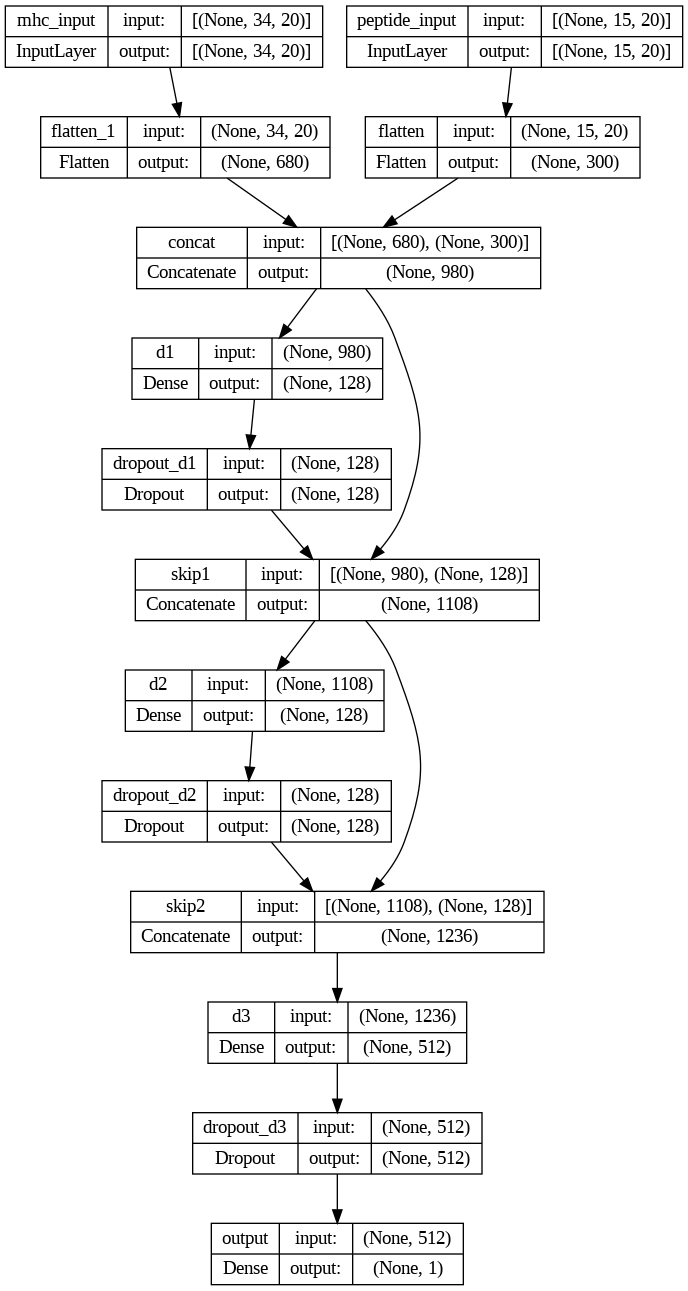

In [207]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [208]:
# Neptune
from neptune.types import File
run["model/model_1_tf_graph"].upload("/content/model_1.png")

In [209]:
# Neptune
run["model/eric_model_1_dir"] = model_dir

In [210]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import inequality_loss
from tensorflow.keras import optimizers, losses

# Define input tensors
BERT_allele = Input(shape=(34, 320))
peptide_allele = Input(shape=(15, 320))

# Dimensionality reduction layers
reduced_allele = Dense(20, kernel_regularizer = tf.keras.regularizers.l1(l=0.01), activation='relu')(BERT_allele)
reduced_peptide = Dense(20, kernel_regularizer = tf.keras.regularizers.l1(l=0.01), activation='relu')(peptide_allele)

# Assume model_1 takes two inputs: [reduced_input_1, reduced_input_2]
# Adjusted to reshape if necessary and connect to model_1
output_1 = model_1([reduced_allele, reduced_peptide])

# Define the new comprehensive model
new_model = Model(inputs=[BERT_allele, peptide_allele], outputs=output_1)

In [211]:
# Neptune
BERT_architecture = {"embedding_layer": "last",
                     "layers": "2 Dense- separate dim reduction",
                     "kernel_regularizer": "l1(l=0.01)",
                     "activation": "relu",
                     "inputs": "BERT_allele (30, 320); peptide_allele (15, 320)",
                     "output": "model_1 on dim reduction of BERT features = 20 dims"}

run["BERT/BERT_architecture"] = BERT_architecture

### Compilation related

In [212]:
# Neptune
model_1_optimizer_params = {"learning_rate": 0.0011339304,
                            "momentum": 0.5,
                            "epsilon": 6.848580326162904e-07,
                            "centered": True,
                            "optimizer_type": "RMSprop"}

run["model/optimizer_params"] = model_1_optimizer_params

In [213]:
optimizer = optimizers.RMSprop(
    learning_rate=model_1_optimizer_params["learning_rate"],
    momentum=model_1_optimizer_params["momentum"],
    epsilon=model_1_optimizer_params["epsilon"],
    centered=model_1_optimizer_params["centered"])

### Make root mean squared

In [214]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [215]:
# Neptune
import json
model_1_compiler_params = {"optimizer": "RMSprop",
                           "loss": "inequality_loss.MSEWithInequalities().loss",
                           "metrics": ["mean_absolute_error", "mean_squared_error", "root_mean_squared_error"]}

# Converts list into correct format.
model_1_compiler_params["metrics"] = json.dumps(model_1_compiler_params["metrics"])
run["model/compiler_params"] = model_1_compiler_params

### Compile the model
Code is not ideal

In [216]:
new_model.compile(optimizer=optimizer, loss=inequality_loss.MSEWithInequalities().loss, metrics=["mean_absolute_error", "mean_squared_error", root_mean_squared_error])

### Check what this `new_model` is like!


In [217]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 34, 320)]            0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 15, 320)]            0         []                            
                                                                                                  
 dense_2 (Dense)             (None, 34, 20)               6420      ['input_3[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 15, 20)               6420      ['input_4[0][0]']             
                                                                                            

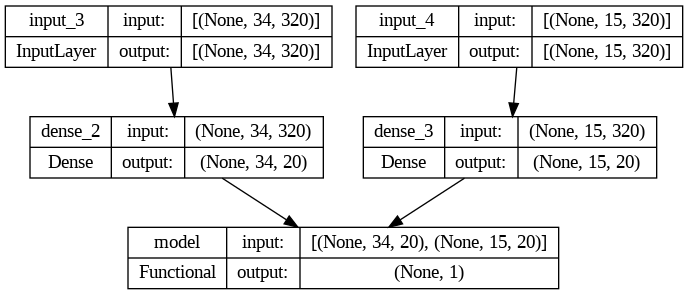

In [218]:
from tensorflow.keras.utils import plot_model
plot_model(new_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [220]:
# Neptune
from neptune.types import File
run["model/tf_graph"].upload("/content/model.png")

### Train the model

In [221]:
training_specs = {"batch_size": 300,
                  "epochs": 300,
                  "shuffle": True,
                  "verbose": 1,
                  "mhc_callbacks": ["monitor=val_loss", "patience=20", "mode=min", "baseline=1", "min_delta=0.0001"],
                  "early_stopping": True,
                  "num_training_samples": 5000,
                  "num_es_samples": 5000}

# Converts list into correct format.
training_specs["mhc_callbacks"] = json.dumps(training_specs["mhc_callbacks"])

# Neptune
run["training/training_specs"] = training_specs

In [222]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.callbacks as Callbacks

mhcglobe_callbacks = [Callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                mode='min',
                baseline=1,
                min_delta=0.0001)]

### Training!

In [223]:
verbose = 1
history = new_model.fit([training_allele_BERT_embeddings, training_peptide_BERT_embeddings], Y_tr,
                        batch_size= 300, #hparams['batch_size'], 10000
                        epochs=300,
                        validation_data=([es_allele_BERT_embeddings, es_peptide_BERT_embeddings], Y_es),
                        shuffle=True,
                        verbose=verbose,
                        callbacks=mhcglobe_callbacks)

Epoch 1/300
17/17 [==============================] - 4s 87ms/step - loss: 3796.4343 - mean_absolute_error: 0.3774 - mean_squared_error: 0.1617 - root_mean_squared_error: 0.3819 - val_loss: 362.5573 - val_mean_absolute_error: 0.0758 - val_mean_squared_error: 0.0073 - val_root_mean_squared_error: 0.0870
Epoch 2/300
17/17 [==============================] - 0s 14ms/step - loss: 204.3403 - mean_absolute_error: 0.0352 - mean_squared_error: 0.0060 - root_mean_squared_error: 0.0766 - val_loss: 159.8925 - val_mean_absolute_error: 0.0262 - val_mean_squared_error: 0.0036 - val_root_mean_squared_error: 0.0537
Epoch 3/300
17/17 [==============================] - 2s 105ms/step - loss: 158.9646 - mean_absolute_error: 0.0285 - mean_squared_error: 0.0054 - root_mean_squared_error: 0.0724 - val_loss: 159.3380 - val_mean_absolute_error: 0.0179 - val_mean_squared_error: 0.0035 - val_root_mean_squared_error: 0.0497
Epoch 4/300
17/17 [==============================] - 0s 13ms/step - loss: 156.6310 - mean_ab

### Save with Neptune!

In [224]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

In [225]:
for i in range(len(loss)):
    run["training/loss"].append(loss[i])
    run["training/val_loss"].append(val_loss[i])
    run["training/mae"].append(mae[i])
    run["training/val_mae"].append(val_mae[i])
    run["training/mse"].append(mse[i])
    run["training/val_mse"].append(val_mse[i])
    run["training/rmse"].append(rmse[i])
    run["training/val_rmse"].append(val_rmse[i])

### Predict using this model!!!

In [226]:
test_allele_pseudoseqs = get_allele_pseudoseqs(human_pMHC_data_test, pMHC)
test_peptide_pseudoseqs = get_peptide_pseudoseqs(human_pMHC_data_test)

# 100, 34, 320
test_allele_BERT_embeddings = get_BERT_embeddings(test_allele_pseudoseqs, tokenizer, model, "tf")
test_peptide_BERT_embeddings = get_BERT_embeddings(test_peptide_pseudoseqs, tokenizer, model, "tf")

### Need to fix the phf file!

In [227]:
# Only has mhcglobe scores.
test_predictions = new_model.predict([test_allele_BERT_embeddings, test_peptide_BERT_embeddings])

4/4 [==============================] - 0s 3ms/step


In [228]:
mhcglobe_scores = new_model.predict([test_allele_BERT_embeddings, test_peptide_BERT_embeddings])

# Get them
mhcglobe_scores = mhcglobe_scores.flatten()
mhcglobe_affinities = list(map(ba.to_ic50, mhcglobe_scores))

prediction_dict = {"mhcglobe_affinities": mhcglobe_affinities, "mhcglobe_scores": mhcglobe_scores}
prediction_df = pd.DataFrame(prediction_dict)

# Munge to_predict so I can correctly concatenate the columns
munged_to_predict = human_pMHC_data_test
munged_to_predict.index = prediction_df.index

# Present the data nicely!
prediction_df_all = pd.concat([munged_to_predict, prediction_df], axis=1)

4/4 [==============================] - 1s 205ms/step


In [229]:
prediction_df_all

,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinities,mhcglobe_scores
0,HLA-A*02:06,RVVDYLTKL,<,100.0,111.843233,0.564030
1,HLA-B*27:05,TRYQTFVNF,<,100.0,111.749649,0.564107
2,HLA-A*02:12,AARHKHQVM,>,20000.0,112.247884,0.563696
3,HLA-B*07:02,IPRSILMTTF,<,100.0,111.911199,0.563974
4,HLA-B*27:05,SRVMDFFRR,<,100.0,111.820587,0.564049
...,...,...,...,...,...,...
95,HLA-C*15:02,RIHDIAVQL,=,196.0,112.008457,0.563894
96,HLA-A*11:01,ALERLLSLKK,=,822.0,111.845685,0.564028
97,HLA-B*27:09,HRVSQDGLNL,<,100.0,111.838545,0.564034
98,HLA-B*57:03,SSSALVSSLHL,<,100.0,112.399788,0.563571


### Save the predictions

In [230]:
from neptune.types import File
run["testing/test_predictions_428364_24_04_05_es_1000"].upload(File.as_pickle(test_predictions))
run["testing/test_predictions_df_all_428364_24_04_05_es_1000"].upload(File.as_pickle(prediction_df_all))

In [231]:
run["testing/test_predictions_df_all_viz_428364_24_04_05_es_1000"].upload(File.as_html(prediction_df_all))

### Set Up Model
Here, I'm accessing a previous model

In [232]:
model_object = neptune.init_model(project="ppaul/MHC-BERT",
                                  api_token=NEPTUNE_API_TOKEN,
                                  with_id="MHCBER-BERT240405"
)

ModelNotFound: No existing Model was found at ppaul/MHC-BERT/MHCBER-BERT240405es1000.

### Make a version

In [234]:
model_version = neptune.init_model_version(project="ppaul/MHC-BERT",
    api_token=NEPTUNE_API_TOKEN,
    model="MHCBER-BERT240405",
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ppaul/MHC-BERT/m/MHCBER-BERT240405/v/MHCBER-BERT240405-1


In [235]:
# model_object["run_id"] = run["sys/id"].fetch()
model_version["run_id"] = run["sys/id"].fetch()

In [236]:
# model_object["num_training_samples"] = len(training_allele_BERT_embeddings)
# model_object["num_es_samples"] = len(es_allele_BERT_embeddings)

model_version["num_training_samples"] = len(training_allele_BERT_embeddings)
model_version["num_es_samples"] = len(es_allele_BERT_embeddings)

In [237]:
# model_object["BERT_architecture"] = BERT_architecture
# model_object["BERT_architecture/model"] = "ESM2_t6_8M_UR50D"

model_version["BERT_architecture"] = BERT_architecture
model_version["BERT_architecture/model"] = "ESM2_t6_8M_UR50D"

In [238]:
# model_object["model/model_1_tf_graph"].upload("/content/model_1.png")
# model_object["model/new_model_tf_graph"].upload("/content/model.png")

model_version["model/model_1_tf_graph"].upload("/content/model_1.png")
model_version["model/new_model_tf_graph"].upload("/content/model.png")

In [239]:
# model_object["optimizer_params"] = model_1_optimizer_params
model_version["optimizer_params"] = model_1_optimizer_params

In [240]:
# model_object["compiler_params"] = model_1_compiler_params
model_version["compiler_params"] = model_1_compiler_params